In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from arch import arch_model
from scipy.stats import t


gas_data = pd.read_csv(
    "../Data/RegGas_wk_data(Adj).csv",
    parse_dates=["date"],
    index_col="date"
)

exog_data = pd.read_csv(
    "../Data/Exog_data.csv",
    parse_dates=["date"],
    index_col="date"
)

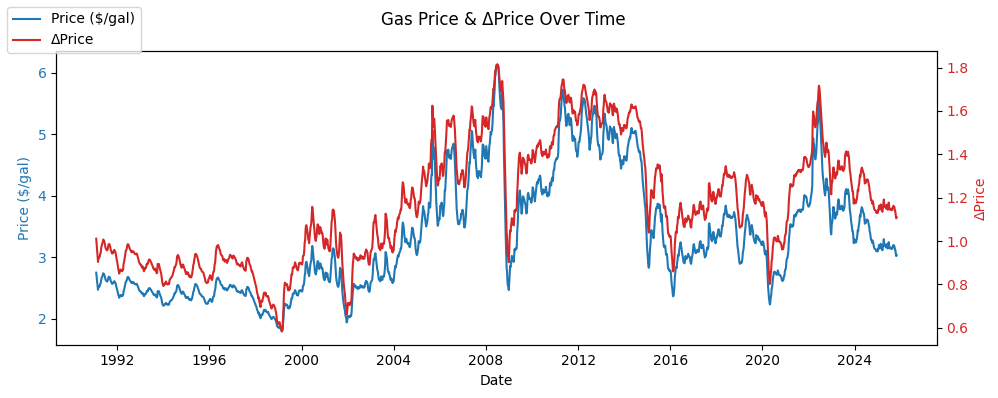

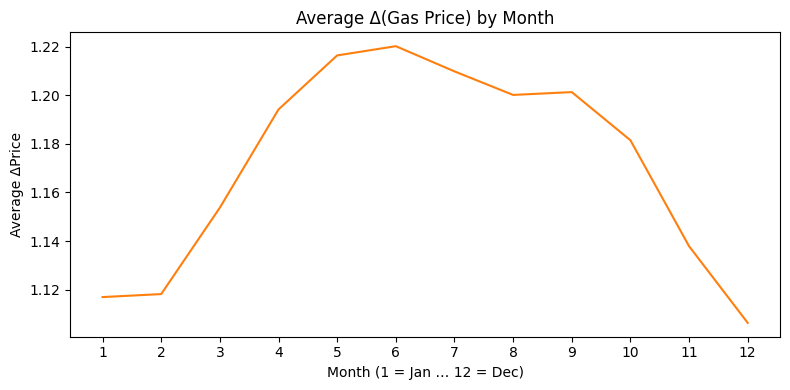

In [2]:
# Full time-series line chart
fig, ax1 = plt.subplots(figsize=(10, 4))
ax1.plot(gas_data.index, gas_data["price"], color="tab:blue", label="Price ($/gal)")    # First axis for price
ax1.set_xlabel("Date")
ax1.set_ylabel("Price ($/gal)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.plot(gas_data.index, gas_data["lprice"], color="tab:red", label="ΔPrice")       # Second axis for ΔPrice
ax2.set_ylabel("ΔPrice", color="tab:red")
ax2.tick_params(axis="y", labelcolor="tab:red")
fig.suptitle("Gas Price & ΔPrice Over Time")
fig.legend(loc="upper left")
fig.tight_layout()

# Seasonal trend: average value per calendar month
monthly = gas_data.groupby(gas_data.index.month)[["price","lprice"]].mean()
fig, ax = plt.subplots(figsize=(8, 4))
monthly["lprice"].plot(ax=ax, color="tab:orange")
ax.set_title("Average Δ(Gas Price) by Month")
ax.set_xlabel("Month (1 = Jan … 12 = Dec)")
ax.set_ylabel("Average ΔPrice")
ax.set_xticks(range(1, 13))
plt.tight_layout()

### Since Log(Price) has the same trend as Price our model should still work. Using Log(Price) should ensure vol model doesn't weigh downside risk as much as upside and never assume that prices can go negative.

### Using Fast-Fourier Transform (FFT) to find dominant seasonal frequencies (annual, semiannual, etc.)

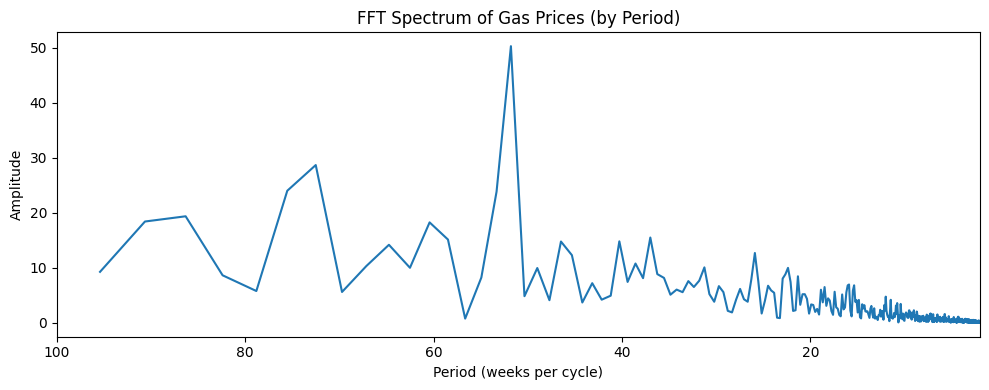

array([51.8])

In [4]:
### USING FAST FOURIER TRANSFORM TO FIND SIGNIFICANT SEASONAL FREQUENCIES ###

y = gas_data["lprice"].values
freqs = fftfreq(len(y), d=1)  # weekly steps
spectrum = np.abs(fft(y))

# Keep only positive frequencies (ignore the mirror half)
pos_mask = freqs > 0
freqs = freqs[pos_mask]
spectrum = spectrum[pos_mask]

# Convert frequency to period (weeks per cycle)
periods = 1 / freqs
mask = (periods >= 2) & (periods <= 100)
periods = periods[mask]
spectrum = spectrum[mask]

# Plot: period on x-axis, amplitude on y-axis
plt.figure(figsize=(10, 4))
plt.plot(periods, spectrum)
plt.title("FFT Spectrum of Gas Prices (by Period)")
plt.xlabel("Period (weeks per cycle)")
plt.ylabel("Amplitude")
plt.xlim(100, 2)  # reverse axis: longer periods on the right
plt.tight_layout()
plt.show()

sorted_idx = np.argsort(spectrum)[::-1]  # reverse order
periods_sorted = periods[sorted_idx]
top_period = periods_sorted[:1]
top_period

## Why use SARIMAX:
- Setting s=52 (since weekly) should capture the seasonality in the gas prices.
- The top chart shows decades of prices that rise, fall, and jump — those jumps around 2008 and 2022 are oil shocks and global disruptions. SARIMAX can handle gradual drifts and mean-reversion fairly well if you difference once (d=1) and putting in a few exogenous regressors (like WTI futures or macro event proxies) should account for external shocks.

## What SARIMAX won’t handle elegantly:
- Sudden, non-recurring spikes (e.g., 2008 crash, 2022 war shock).
- Regime changes (if the whole mean level shifts permanently).
You’ll see wide residuals in those zones — but that’s fine, GARCH can mop up the volatility.

Good exogneous variables should help us account for those macro bkack-swan events and regime changes

## Why Use Fourier Terms:
Gas prices are mostly deterministic in their seasonal rhythm but stochastic in their shocks.

Every year:
- Refineries switch to summer blends (≈ spring).
- Driving demand peaks in early summer.
- Demand eases post-Labor Day.
- Refinery maintenance + winter blends lower prices.

That schedule is grounded in regulation and demand cycles. The timing is roughly the same each year — **deterministic**.

But the magnitude of the swings — how high prices go, how sharp the drop — depends on crude markets, wars, hurricanes, etc. — **stochastic**.

So:
- The seasonal shape is deterministic -> capture it with Fourier terms.
- The noise and volatility are stochastic -> capture those with ARIMA/GARCH parts.

In [5]:
# We use this to get fourier regressors for our pre-determined most significant seasonal frequencies
def fourier_custom(df_index, periods):
    """
    Creates Fourier regressors for user-specified periods.
    periods: list of cycle lengths (in weeks)
    """
    t = np.arange(len(df_index))
    X = {}
    for i, p in enumerate(periods, start=1):
        X[f'sin_{i}'] = np.sin(2 * np.pi * t / p)
        X[f'cos_{i}'] = np.cos(2 * np.pi * t / p)
    return pd.DataFrame(X, index=df_index)

## Fitting SARIMAX Model:

In [34]:
y = gas_data["lprice"]

h = 4  # forecast horizon of 4 weeks
last_date = gas_data.index[-1]
future_index = pd.date_range(start=last_date+pd.Timedelta(days=1), periods=h, freq='W-MON')[:]  # 4 future weeks
full_index = gas_data.index.append(future_index)

exog_vars = ["RBOB_F_1m"]               # crack spread and WTI Futures are insignificant to model
exog_extended = pd.concat([exog_data, pd.DataFrame(index=future_index)])    # extending to use for prediction later
for col in ["RBOB_F"]:
    exog_extended[f"{col}_1m"] = exog_extended[col].shift(4)        # 1 month lag
X_full = fourier_custom(full_index, top_period)                    # feeding in seasonality as exog vars
X_full = X_full.join(exog_extended[exog_vars], how="left")               # adding exogenous variables: Crack spread, RBOB and WTI Futures etc

# Split into in-sample and future parts
X_train = X_full.loc[gas_data.index]
X_future = X_full.loc[future_index]

model = SARIMAX(
    y,
    exog=X_train if 'X_train' in locals() else None,
    order=(1, 0, 1),             # ARIMA part, differencing not needed since inflation adj. removed trends
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)

naive_pred = y.shift(1)
rmse_model = mean_squared_error(y[1:], results.fittedvalues[1:])
rmse_naive = mean_squared_error(y[1:], naive_pred[1:])
print(f"Model-to-Naive RMSE Ratio: {rmse_model / rmse_naive}")  # If ratio < 1, model is beating the “just use last week’s price” dumb forecast.
print(results.summary())

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Model-to-Naive RMSE Ratio: 0.718481330610025
                               SARIMAX Results                                
Dep. Variable:                 lprice   No. Observations:                 1813
Model:               SARIMAX(1, 0, 1)   Log Likelihood                4924.404
Date:                Thu, 30 Oct 2025   AIC                          -9836.808
Time:                        13:07:37   BIC                          -9803.798
Sample:                    02-04-1991   HQIC                         -9824.626
                         - 10-27-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sin_1         -0.0155      0.007     -2.208      0.027      -0.029      -0.002
cos_1         -0.0508      0.006     -8.408      0.000      -0.063      -0.039
RBOB_F_

The exogenous variables: Geopolitical Risk Index, WTI Crude Oil Futures, and Crack Spread are not significant regressors for the SARIMAX hence we don't use them.

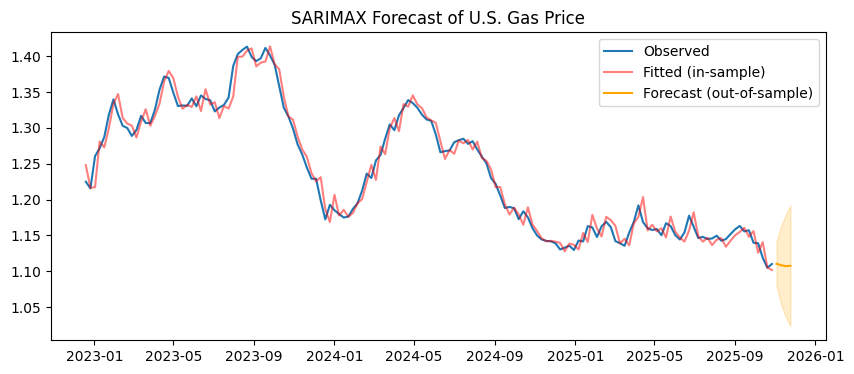

In [35]:
hist = y.iloc[-150:]  # your observed series (last ~150 weeks)
fitted = results.fittedvalues[-150:]
smx_forecast = results.get_forecast(steps=h, exog=X_future if 'X_future' in locals() else None)
smx_mean = smx_forecast.predicted_mean
smx_ci = smx_forecast.conf_int()

plt.figure(figsize=(10,4))
plt.plot(hist, label='Observed')
plt.plot(fitted, label='Fitted (in-sample)', color='red', alpha=0.5)
plt.plot(smx_mean.index, smx_mean, label='Forecast (out-of-sample)', color='orange')
plt.fill_between(smx_ci.index, smx_ci.iloc[:, 0], smx_ci.iloc[:, 1], color='orange', alpha=0.2)
plt.legend()
plt.title("SARIMAX Forecast of U.S. Gas Price")
plt.show()

## Fitting GARCH Model on Variance

In [36]:
resid = results.resid.dropna()
resid_scaled = resid * 100 

garch = arch_model(resid_scaled, vol='GARCH', p=1, q=1, mean='Zero', rescale=False, dist='t')
garch_fit = garch.fit(disp="off")
print(garch_fit.params)
print(garch_fit.summary())

omega       0.212418
alpha[1]    0.304058
beta[1]     0.650278
nu          5.254570
Name: params, dtype: float64
                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.001
Vol Model:                            GARCH   Log-Likelihood:               -3168.88
Distribution:      Standardized Student's t   AIC:                           6345.76
Method:                  Maximum Likelihood   BIC:                           6367.78
                                              No. Observations:                 1813
Date:                      Thu, Oct 30 2025   Df Residuals:                     1813
Time:                              13:07:43   Df Model:                            0
                             Volatility Model                             
                 coef    std err          t    

## Combining SARIMAX and GARCH for Monte Carlo

In [56]:
# mean from SARIMAX
mu = smx_mean.to_numpy()

# GARCH volatility forecast (use your t-dist fit)
g_fore = garch_fit.forecast(horizon=h)
sigma = np.sqrt(g_fore.variance.values[-1])/100  # length h, /100 for de-scaling
nu = garch_fit.params['nu'] # degrees of freedom

### Monte Carlo with Student-t shocks ###

rng = np.random.default_rng(42)
n_sims = 10000
eps = rng.standard_t(nu, size=(n_sims, h)) * sigma      # simulate i.i.d. Student-t innovations with time-varying sigma
yT = float(y.iloc[-1])                                  # yT: last observed log-price

# Compute expected incremental mean changes (Δμ)

delta_mu = np.empty(h)
delta_mu[0]  = mu[0] - yT
delta_mu[1:] = mu[1:] - mu[:-1]

dlog = delta_mu.reshape(1, -1) + eps        # Combine mean changes + random shocks
log_paths = yT + np.cumsum(dlog, axis=1)    # Each row: one simulated log-price path starting from last observed value
paths = np.exp(log_paths)                   # Convert back to dollar prices

# Proportion of paths that end up above X.XX$
for price in np.arange(2.90, 3.10, 0.05):
    price_bucket = np.round(price, 2)
    prop = (paths[:, -1] >= price_bucket).mean()
    print(f"Proportion above {price_bucket}: {prop:.2%}")

Proportion above 2.9: 89.09%
Proportion above 2.95: 77.48%
Proportion above 3.0: 59.37%
Proportion above 3.05: 39.91%
Proportion above 3.1: 23.54%


In [62]:
np.mean(paths[:, -1])

np.float64(3.0275358780437935)

## Plotting Median Monte Carlo Path

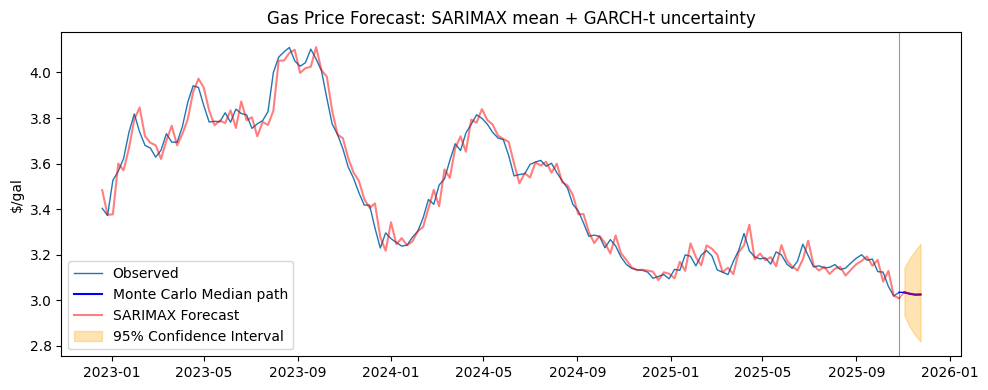

In [93]:
# percentiles for bands
q = np.percentile(paths, [2.5, 50, 97.5], axis=0)

# pick a recent history window for context
hist = y.iloc[-150:]  # your observed series (last ~150 weeks)
future_idx = smx_mean.index  # same index as mu/sigma

plt.figure(figsize=(10,4))
plt.plot(hist.index, np.exp(hist.values), label="Observed", lw=1)
plt.plot(np.exp(fitted), color='red', alpha=0.5)
plt.axvline(hist.index[-1], color='k', lw=0.8, alpha=0.4)

# median path
plt.plot(future_idx, q[1], label="Monte Carlo Median path", color="blue")

# SMX mean
plt.plot(future_idx, np.exp(smx_mean), label="SARIMAX Forecast", color="red", alpha=0.5)

# draw a connector from last obs to median & SMX mean for continuity
plt.plot([hist.index[-1], future_idx[0]], [np.exp(hist.iloc[-1]), q[1,0]], color='blue', lw=1)
plt.plot([fitted.index[-1], future_idx[0]], [np.exp(fitted.iloc[-1]), np.exp(smx_mean.iloc[0])], color='red', lw=1, alpha=0.5)

# 25-75 band
plt.fill_between(future_idx, q[0], q[2], label="95% Confidence Interval", color="orange", alpha=0.3)

plt.title("Gas Price Forecast: SARIMAX mean + GARCH-t uncertainty")
plt.ylabel("$/gal")
plt.legend()
plt.tight_layout()
plt.show()

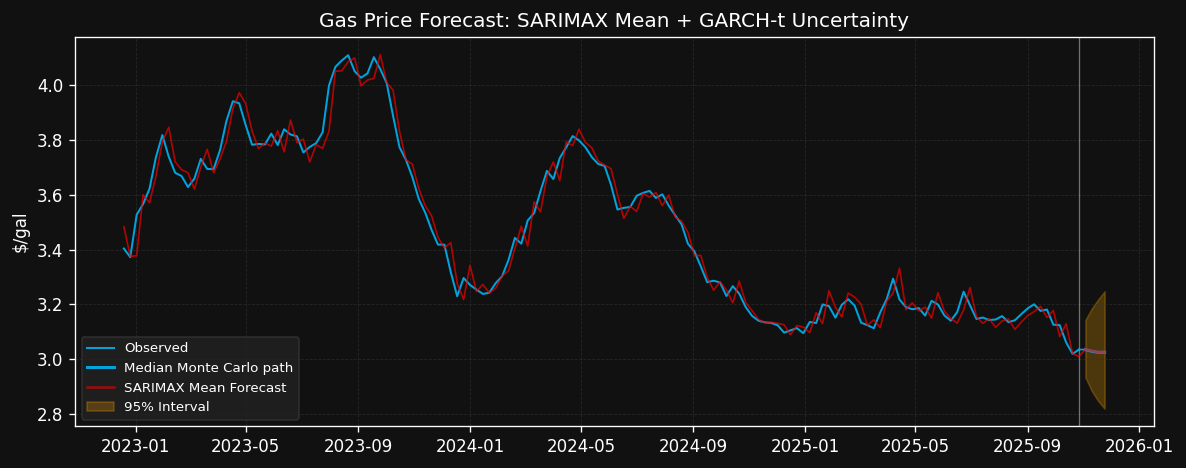

In [104]:
# Percentiles for bands
q = np.percentile(paths, [2.5, 50, 97.5], axis=0)

# History window
hist = y.iloc[-150:]
future_idx = smx_mean.index

# --- Dark mode setup ---
plt.style.use("dark_background")
fig, ax = plt.subplots(figsize=(10, 4), facecolor="#111", dpi=120)
ax.set_facecolor("#111")

# --- Plot elements ---
ax.plot(hist.index, np.exp(hist.values), label="Observed", color="#02A3DD", lw=1.2)
ax.plot(np.exp(fitted), color="#F30000", alpha=0.7, lw=1)
ax.axvline(hist.index[-1], color="white", lw=0.8, alpha=0.4)

# Median path
ax.plot(future_idx, q[1], label="Median Monte Carlo path", color="#02A3DD", lw=1.8)

# SARIMAX mean
ax.plot(future_idx, np.exp(smx_mean), label="SARIMAX Mean Forecast", color="#F30000", alpha=0.6, lw=1.5)

# Connectors for continuity
ax.plot([hist.index[-1], future_idx[0]],
        [np.exp(hist.iloc[-1]), q[1, 0]], color="#02A3DD", lw=1)
ax.plot([fitted.index[-1], future_idx[0]],
        [np.exp(fitted.iloc[-1]), np.exp(smx_mean.iloc[0])],
        color="#F30000", lw=1, alpha=0.7)

# 95% Confidence Interval band
ax.fill_between(future_idx, q[0], q[2],
                color="#FFA500", alpha=0.25, label="95% Interval")

# --- Aesthetics ---
ax.set_title("Gas Price Forecast: SARIMAX Mean + GARCH-t Uncertainty", color="white", fontsize=12)
ax.set_ylabel("$/gal", color="white")
ax.tick_params(colors="white")
ax.legend(facecolor="#222", edgecolor="#333", labelcolor="white", fontsize=8)
ax.grid(color="#333", linestyle="--", linewidth=0.5, alpha=0.6)

plt.tight_layout()
plt.show()

In [81]:
q[:, -1]

array([2.81911525, 2.95824151, 3.02529972, 3.09468454, 3.24757584])